### **ECO 504: Part II, Problem Set 3**  

* *Original Author:* Emily Merola
* *First created:* 2023.04.19
* *Last updated:* 2023.04.19
* *Collaborated with:* Cam Ricciardi

#### **Question 1**
##### Part (a) 
Write a code to approximate the above income process using the Tauchen method with a five-state Markov chain.

In [2]:
# Housekeeping
using LinearAlgebra, Plots, SparseArrays, Random, Statistics, Parameters, BenchmarkTools, PiecewiseLinearApprox, Optim, Distributions

In [3]:
# What do we need for the Tauchen method? Let's do a quick review of the slides.

# Information about our process for yt / the underlying parameters

    # ϵ (error)
    μϵ = 0.0
    σϵ_sq = 0.06
    σϵ = sqrt(σϵ_sq)

    # W (AR(1) process)
    ρ = 0.9                                     #coefficient on the lagged term
    wbar = (-1/2) * ((1-ρ)/(1-ρ^2)) * σϵ_sq     #see handwritten work. chosen to make E[Y] = 1
    μW = wbar/(1-ρ)
    σW_sq = σϵ_sq/(1-ρ^2)
    σW = sqrt(σW_sq)

    # Y (income)
    μY = exp(μW + (σW_sq)/2 )
    σY_sq = (exp(σW_sq) - 1)*exp(2μW + σW_sq) 

0.37134152175580604

In [61]:
# Function to run the Tauchen method
# after comparing with Cam, realized that it would be much easier to do this for W, and then generate Y values after that.
function  Tauchen(N,m)

    # Maybe the issue is that this grid of possible realizations is too wide

    # Grid of possible realizations of w
    wtilde = zeros(N)
    wtilde[N] = (m * sqrt(σW_sq)) + μW         #"Tauchen (1986) suggests a multiple of the unconditional standard deviation"
    wtilde[1] = μW - (m * sqrt(σW_sq))
    d = (wtilde[N] - wtilde[1])/(N-1)

    for i in 2:N-1
    wtilde[i] = wtilde[1]+(d*(i-1))
    end
    
    # Transition probabilities
    function F(μ, σ_sq, x)
        cdf(Normal(μ, σ_sq), x)
    end

    πW = zeros(N,N) 
    # π[j,k]
    for j in 1:N
        #interior
        for k in 2:N-1
            left = (wtilde[k] - wbar + (d/2) - ρ*wtilde[j])/σϵ
            right = (wtilde[k] - wbar - (d/2) - ρ*wtilde[j])/σϵ
            πW[j,k] = F(0.0, 1.0, left) - F(μϵ, 1.0, right)  
        end
        #boundaries
        x1 = (wtilde[1] - wbar + (d/2) - ρ*wtilde[j])/σϵ
        x2 = (wtilde[N] - wbar - (d/2) - ρ*wtilde[j])/σϵ
        πW[j,1] = F(0.0, 1.0, x1)
        πW[j,N] = 1 - F(0.0, 1.0, x2)
    end

    # For reference later: the potential y-values that correspond to the w-values we've generated here
    ytilde = exp.(wtilde)

    return tauchen = (πW = πW, wtilde = wtilde, ytilde=ytilde)
end

# you could imagine looping the below if you wanted to see how different values affected this more granularly (I'm imagining a gif here!)
tauchen5 = Tauchen(5,3)
πW5 = tauchen5.πW
wtilde5 = tauchen5.wtilde

tauchen10 = Tauchen(10,3)
πW10 = tauchen10.πW
wtilde10 = tauchen10.wtilde

tauchen100 = Tauchen(100,3)
πW100 = tauchen100.πW
wtilde100 = tauchen100.wtilde

test = sum(πW5[1,:]) # good to go!

1.0

In [27]:
# Plotting the income process

# First: how to plot the continuous process?

    # we could set a seed and sample from the distribution we've laid out
    # and then plot those realizations for like 100 values or something.

    # sampling from the distribution of y's

    periods = 1000
    periods2 = 1000.0

    # we need to sample the EPSILONS and the the first Wt (ugh)

        wgrid = zeros(periods,periods)          #suppose we start at w_1 = 0.0
        # what if we started at a higher value instead?

        for j in 1:periods
        
        #pull our iid epsilons
        Random.seed!(761756492 + (1*(j-1)))         # pulled between 1 and 999999999 from Random.org (because why not?)
        d = Normal(0.0 , σϵ)                      # we'll see if this needs to change
        ϵgrid = rand(d, periods)

        for i in 2:periods
        wgrid[i,j] = wbar + ρ*wgrid[i-1,j] + ϵgrid[i]
        end
    end

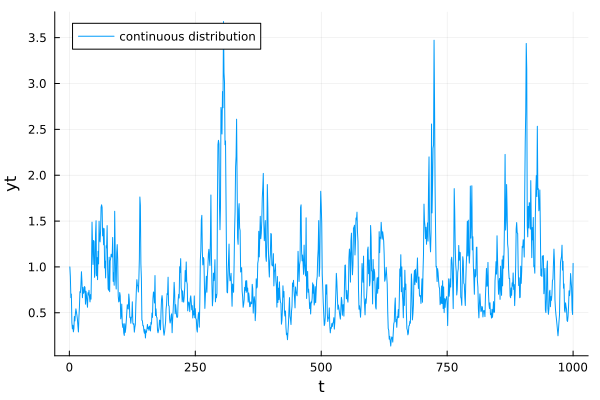

In [28]:
    ygrid = exp.(wgrid)
    continuous_mean = mean(ygrid)           # ok so something is definitely going wrong here (avg too low), but I'm not sure what. 

    #t grid for Plotting
    tgrid = collect(range(1.0,periods2,step=1))

    ygrid_plot = ygrid[:,1] # just the first of many 

    #plot
    a = plot(tgrid, ygrid_plot, label = "continuous distribution", xlabel="t", ylabel="yt")

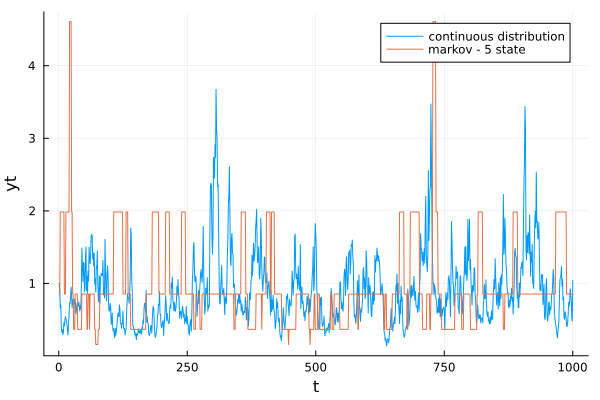

In [29]:

# Adapting to our 5-state markov matrix. See resource here https://julia.quantecon.org/introduction_dynamics/finite_markov.html

function mc_sample_path(P; init = 1, sample_size = periods, seed = 761756492)
    
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state
    
    Random.seed!(seed) #
    
    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

wstates5 = mc_sample_path(πW5, init = 3, sample_size = periods);
wgrid5 = zeros(periods)
for i in 1:periods
wgrid5[i] = wtilde5[wstates5[i]]
end

ygrid5 = exp.(wgrid5) # I'm coming around to the look of this plot. Maybe it's just the "burn in period" that matters?
b = plot(a, tgrid, ygrid5, label = "markov - 5 state", xlabel="t", ylabel="yt")

# test = mean(ygrid5)
# test2 = var(ygrid5)

# c = plot(tgrid, wgrid5, label = "markov - 5 state", xlabel="t", ylabel="wt")
#The only explanation I can give myself for why the continuous distribution isn't matching as well:
#this is just ONE realized path, rather than MANY? But I still don't find this super convincing. 
#plus, even if we should be capturing "many paths" and that's the problem, it's AR(1)! So the initial value shouldn't affect so much.
#finally, this should be reflecting an income process anyway! So what does it matter if it's just one realized path.


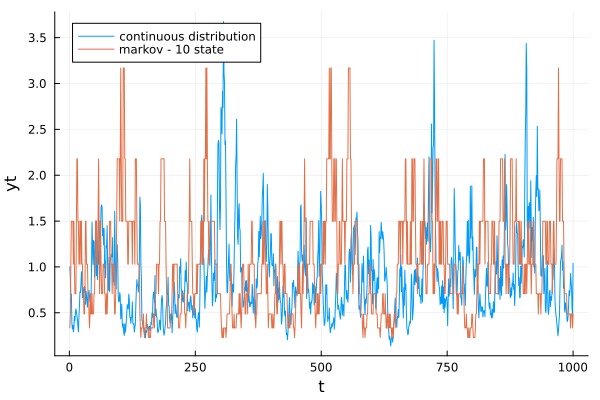

In [32]:
wstates10 = mc_sample_path(πW10, init = 3, sample_size = periods);
wgrid10 = zeros(periods)
for i in 1:periods
wgrid10[i] = wtilde10[wstates10[i]]
end

ygrid10 = exp.(wgrid10) # still not stuper convincing, but it's definitely better! Let's check out a 50 state version for fun
b = plot(a, tgrid, ygrid10, label = "markov - 10 state", xlabel="t", ylabel="yt")

# test = mean(ygrid10)

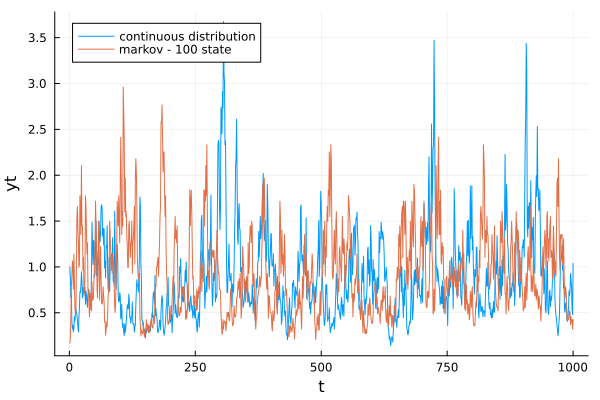

In [33]:
wstates100 = mc_sample_path(πW100, init = 3, sample_size = periods);
wgrid100 = zeros(periods)
for i in 1:periods
wgrid100[i] = wtilde100[wstates100[i]]
end

ygrid100 = exp.(wgrid100) # The variance looks off, here, and I would have expected something better.
b = plot(a, tgrid, ygrid100, label = "markov - 100 state", xlabel="t", ylabel="yt")

# I think the issue is the autocorrelation